## **Harnessing Machine Learning for Seismic Phase Picking in the cloud**

Seismology is exploding with data. With thousands of sensors collecting terabytes of waveforms through networks like the SAGE facility, there’s more data than any human (or team of humans) can comb through by hand. That’s where machine learning (ML) comes in. ML lets computers learn patterns from data, such as recognizing earthquake signals or picking out P and S wave arrivals, without being explicitly told the rules. Instead of writing rigid algorithms, we let the computer figure it out from examples. Think of it as training a dog to sit. You don’t teach it every muscle to move; you reward it when it gets it right. Over time, it just learns. That’s exactly what we do when we train ML models on seismic data.

##### 🔹 **Why use machine learning?**

Imagine this: your research project involves analyzing **500,000 earthquakes** recorded by hundreds of stations over several years. You have two choices:
1. Manually pick through half a million waveforms (say goodbye to your weekends), or
2. Train a machine learning model to do it for you—fast, consistently, and while you grab coffee.

Modern seismic and geodetic networks like SAGE and GNSS generate massive amounts of data—more than any human can reasonably sift through. That’s where ML shines.

**~ Pattern Recognition in Big Data**
- Detects trends, anomalies, and hidden signals in time-series and spatial data.
- Classifies seismic events (e.g., quakes, explosions, tremors) much faster than traditional methods.

**~ Speed & Scalability**
- ML models can detect and characterize seismic events in real-time.
- They can also crunch through years of archived data in hours, enabling large-scale retrospective studies and catalog building.

**~ Noise? No Problem**
- It can separate meaningful signals from background clutter.
- Denoising autoencoders can even reconstruct clean waveforms from noisy recordings.

**~ Better Earthquake Locations & Magnitudes**
- Works well even with sparse or noisy data.
- Combines seismic, GNSS, and other datasets for improved accuracy.

**~ Forecasting & Anomaly Detection**
- ML can spot subtle precursors to large quakes or volcanic activity.
- In geodesy, it can detect transient events like slow slip or post-seismic rebound—tricky to isolate otherwise.

<img src="https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202002/MIT-Seismic-Deep-Fake-01_0.jpg?itok=BP7XV0Qz" alt="DASK" width="650"/>


> *⭕ **Reflection Question**: In our imaginary research project, you need to process 500,000 seismograms to train your machine learning model. That’s a lot of data! Knowing that these seismograms are already stored on an EarthScope-managed cloud server (and ready to be streamed), ask yourself: Where would building and training your model be more time-effective—on your local computer or in a cloud-native environment? Think about data access, processing speed, scalability, and what you’ve learned in the previous notebooks. 💡 Hint: Moving massive datasets across the internet takes time. But if the data is already in the cloud... why move it?*

---

##### 🔹 **Machine 'LEARNING'?**

Now that we've seen how machine learning can revolutionize seismic data processing—especially in the cloud—let's take the next step: actually training a model.

Machine learning isn't magic. At its heart, it's pattern recognition through exposure to examples. To pick out seismic phases (like P and S wave arrivals), a model needs to learn from waveforms labeled by experts. This process is called training. And thanks to cloud-native resources like SAGE-hosted seismograms and scalable compute, we can train robust models without moving a single file off the server.

Before diving into advanced architectures, let’s warm up with a simple example of how a model learns from labeled waveform data.

Below is a small Python code snippet using NumPy and PyTorch to simulate training a tiny neural network to classify a synthetic waveform segment as either “noise” or “phase arrival.” It’s meant to be illustrative, not production-ready. Be sure understand it before jumping onto next sections.

**🔧 Mini Code Snippet: “Toy Model” for Seismic Phase Picking**


In [ ]:
!pip install torch

Epoch 0, Loss: 0.6407
Epoch 5, Loss: 0.4153
Epoch 10, Loss: 0.3418
Epoch 15, Loss: 0.3199


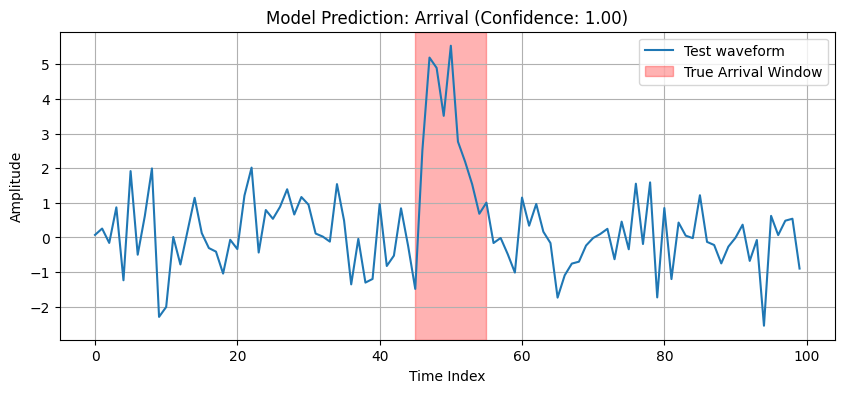

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Synthetic Data Generator
# ----------------------------
# This function simulates a seismic waveform.
# If `has_arrival=True`, it inserts a synthetic "phase arrival"
# by adding a sine wave burst in the middle of Gaussian noise.
def generate_waveform(has_arrival=True):
    x = np.random.randn(100)  # Simulated background noise
    if has_arrival:
        x[45:55] += np.sin(np.linspace(0, np.pi, 10)) * 5  # Add synthetic arrival
    return x

# -------------------------------------
# 2. Create a Dataset of 1000 Waveforms
# -------------------------------------
# Half of the waveforms will contain phase arrivals, half will be noise only.
X = np.array([generate_waveform(i % 2 == 0) for i in range(1000)])

# Create labels: [1, 0] means 'arrival'; [0, 1] means 'noise'
y = np.array([[1, 0] if i % 2 == 0 else [0, 1] for i in range(1000)])

# -----------------------------------------
# 3. Convert Data to PyTorch Tensor Format
# -----------------------------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# ----------------------
# 4. Define a Simple Model
# ----------------------
# A shallow neural network with:
# - One hidden layer (32 units, ReLU)
# - Output layer (2 units, Softmax for classification)
model = nn.Sequential(
    nn.Linear(100, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
    nn.Softmax(dim=1)  # Output: probability of [arrival, noise]
)

# --------------------
# 5. Train the Model
# --------------------
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(20):
    optimizer.zero_grad()               # Reset gradients
    outputs = model(X_tensor)           # Forward pass
    loss = criterion(outputs, y_tensor) # Compute loss
    loss.backward()                     # Backpropagation
    optimizer.step()                    # Update weights
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ---------------------------
# 6. Test on a New Waveform
# ---------------------------
# Generate a new waveform with an arrival
test_waveform = torch.tensor(generate_waveform(True), dtype=torch.float32)
test_input = test_waveform.unsqueeze(0)  # Add batch dimension

# Get prediction from model
prediction = model(test_input).detach().numpy()
predicted_label = 'Arrival' if np.argmax(prediction) == 0 else 'Noise'
confidence = np.max(prediction)

# ---------------------------
# 7. Plot Waveform and Result
# ---------------------------
plt.figure(figsize=(10, 4))
plt.plot(test_waveform.numpy(), label='Test waveform')
plt.axvspan(45, 55, color='red', alpha=0.3, label='True Arrival Window')
plt.title(f"Model Prediction: {predicted_label} (Confidence: {confidence:.2f})")
plt.xlabel("Time Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

> *⭕ **Reflection Question**: What patterns do you think this tiny model is using to distinguish between noise and a seismic arrival? How might real seismic data challenge this model’s assumptions?*

---

##### 🔹 **Training your model**

In our toy example, we trained a basic neural network to classify a seismic waveform as either containing a phase arrival or just noise. That’s a great first step—it demonstrates how machine learning can spot meaningful patterns in messy signals. But in real-world seismology, knowing that a waveform contains an arrival isn’t enough. Scientists need to know exactly when the P or S wave hits. For that, we need models that don’t just classify an entire waveform, but label every time step with precision.

“Training a model” means feeding it lots of labeled examples, like seismograms with known phase arrivals, and letting it learn the connection between the raw waveform and the arrival times. At first, the model guesses randomly. But with each guess, it gets feedback (how wrong it was), and it adjusts its inner logic (called parameters) to do better next time. After enough rounds, the model gets pretty good at spotting patterns — even in brand new data it's never seen before.

##### 🔹 **Meet U-net**

When it comes to finding where something is inside messy data (like an earthquake hiding in noise), one of the most effective tools is called the U-Net. Originally created for segmenting medical images (like finding tumors in MRI scans), U-Net has found a new job in seismology: picking out seismic phases from waveform data.

How does it work? Think of it like this:

1. 👀 It zooms out to understand the big picture (what's happening over time).
2. 🔍 Then it zooms back in, focusing on fine details to pinpoint exactly where the interesting stuff is — like a P-wave arrival.

Even better, it brings along notes from the zoomed-out view so it doesn’t forget anything. This “zoom out and back in” strategy is why it's shaped like a U — wide on the sides, narrow in the middle.

U-Net works well on seismograms for a few key reasons:

- It combines context and detail — it sees the whole trace and also zooms in on precise moments.
- It’s efficient — it can learn a lot even from a relatively small number of labeled waveforms.
- It’s precise — it highlights the exact sample or time a seismic phase arrives.
- It’s flexible — it works for 1D traces, 2D waveform images, or even full event catalogs.
- All this makes it a favorite for seismic phase picking and event detection.

Training a deep learning model like U-Net takes time, power, and lots of data. Traditionally, that meant setting up local machines, transferring files, and managing storage — all of which can slow you down.

But now, SAGE data is hosted in the cloud, and that changes everything.

- You can stream waveform data directly into your ML pipeline.
- Use cloud GPUs or TPUs to train models in parallel.
- Automate your workflows using tools like Dask, Kubernetes, or prefect.io.
- Reproduce and share everything with portable, containerized environments.

In short: cloud-optimized workflows make training ML models on seismic data faster, cheaper, and more scalable than ever before.

This is how a basic U-net architecture works

<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/gji/216/1/10.1093_gji_ggy423/1/m_ggy423fig5.jpeg?Expires=1754919728&Signature=41lJnaVjzCCW1i7utY-eOebfBdjeh7ykYBMBIqT0yyFLj3PCn60KlQD96BDL8kuQRxugnvm3BUxljgkI6VB6UcMNjIFXKamdpVuDpzjgwjMNwiZCdjOr1ygjxpixGkMHfzFV1w0y9JkY60gwVSZvhe4BlGfjAuuTZb9-6gVcxpLvQtFiOddFB6QpOblUD4RVFezUgbeCTa2VA4OI6O91G7DrWGR7EtSP~QAkYhqG4l~VmQTLxcZWijRHDEr~XGcPXlgR77x7NtRschgq6IHf0i7lv8F4MfbkMnvIDmkAm5m1pUQT8Q2SSyji9hT~p-NAyKhSEXuGFodua-SCpXWytg__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="DASKscaling" width="600"/>

---

### **1. Building U-net**

Alright, time to dive into building our U-Net model, starting from the Encoder side of the architecture. This is the part of the network that acts like a detective—it looks at the raw waveform and tries to extract the most important clues by gradually compressing the information.

**Take a look at the U-Net diagram above: what’s the very first thing you notice in the encoder path?**

You’ll see two operations repeated right at the beginning: a `convolution` followed by a `ReLU` activation... and then the same thing again! This pattern—two `convolution + ReLU` blocks in a row—appears throughout the U-Net and is a key building block.

To make things modular and reusable, let’s package this pattern into its own component. We’ll call it `ConvBlock`

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ═══════════════════════════════════════════════════════════════════════════════════════
# Double Convolution Block
# ═══════════════════════════════════════════════════════════════════════════════════════
class ConvBlock(nn.Module): # inherit the base class for neural networks for PyTorch
    """
    ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
    │ ConvBlock: The basic building brick                                                                                                           │
    │ ----------------------------------------------------------------------------------------------------------------------------------------------│
    │ • Two 1-D convolutions (doubleConv), each followed by BatchNorm, ReLU and Dropout.                                                            │
    │ • Conv1D = Applies a 1D convolution over an input seismogram signal                                                                           │
    │ • BatchNorm1D = Normalizes the output of the convolution by having zero mean and unit variance across the mini-batch during training          │
    │ • ReLU = Applies the Rectified Linear Unit activation function, which sets all negative values to zero and keeps positive values unchanged.   │
    │ • Dropout = Randomly sets a fraction of input units to zero during training to prevent overfitting.                                           │
    └───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
    """
    def __init__(self, 
                 in_channels,     # Number of input channels (e.g., waveform channels)
                 out_channels,    # Number of output channels (i.e., number of feature maps)
                 kernel_size = 3, # Size of the convolutional filter (default is 3x3)
                 padding=1,       # Padding for the convolution (default is 1 to preserve size)
                 dropout=0.1):    # Dropout rate
        super().__init__() # Initialize the base class

        # Define a sequential block of two convolutional layers with batch normalization, ReLU activation, and dropout
        # This block will be used to extract features from the input signal
        self.doubleConv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout1d(dropout),
            
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout1d(dropout)
        )

    #------FORWARD PASS THROUGH THE CONVOLUTION BLOCK--------
    # This method defines how the input data flows through the block
    # It takes an input tensor 'x' and applies the double convolution defined above
    # The output is a tensor with the same number of channels as defined by 'out_channels'
    # The input tensor 'x' is expected to have shape (batch_size, in_channels)
    def forward(self, x):
        return self.doubleConv(x)

> *⭕ **Reflection Question**: What’s the difference between the convolution block in our code and the one in the original diagram? Why do you think we added extra layers like BatchNorm, ReLU, and Dropout?*

Think of the `ConvBlock` as the Lego brick of our U-Net architecture. It extracts features from the waveform by stacking two convolutional layers, each followed by normalization and activation. But one building block alone doesn’t make a full model.

Just like assembling a house from bricks, the full U-Net is made by stacking multiple blocks together—in a very particular way. That brings us to our next step: putting these blocks into a complete encoder-decoder structure that can both understand the waveform and make precise, time-step-level predictions.

instead of a one-size-fits-all model, we’re building an `AdaptiveUNet1D`—a version designed specifically for seismic workflows. Its
- smart enough to work with or without expert-crafted features
- flexible across waveform lengths and sampling conditions
- focused on time-domain precision (perfect for phase picking)

This architecture is designed specifically for 1D seismic data, and includes:
- An encoder to learn “what’s present” in the waveform
- A decoder to learn “when exactly” key events (like P or S arrivals) occur
- Optional physics-informed features like STA/LTA, if you want to combine expert knowledge with machine learning


In [20]:
# now, we are going to create the entire U-net structure

class AdaptiveUNet1D(nn.Module):
    """
    ┌──────────────────────────────────────────────────────────────────────────────────────┐
    │ Adaptive 1-D U-Net                                                                   │
    │ ──────────────────────────────────────────────────────────────────────────────────── │
    │ • Goal: predict a label for every time sample (e.g.,  P-wave arrival).               │
    │ • Shape convention: (batch, channels, length) — PyTorch’s default.                   │
    │ • Two big parts:                                                                     │
    │     Encoder (Down path): “What is present?”                                          │
    │     Decoder (Up path)  : “Where exactly is it?”                                      │
    │   Skip connections copy high-resolution info from encoder to decoder.                │
    │ • Can work with or without physics-informed features                                 │
    │ • Batch normalization and dropout for better generalization                          │
    │ • Multi-scale feature extraction through encoder-decoder architecture                │
    │ • Dynamically adapts to different input channel sizes                                │
    └──────────────────────────────────────────────────────────────────────────────────────┘
    """
    
    def __init__(self, 
                 in_channels=1, 
                 out_channels=2,              # number of output channels (e.g., 2 for binary classification)
                 features=[32, 64, 128, 256], # network width; doubles every step by default
                 dropout=0.1,                 # dropout rate for regularization
                 use_physics_features=True    # whether to use physics-informed features (e.g., STA/LTA, envelope, spectral)
                 ):
        super().__init__()
        
        self.in_channels = in_channels
        self.use_physics_features = use_physics_features
        
        # ==============================
        # 1️⃣ Downsampling Path (ENCODER)
        # ==============================
        # Build the ENCODER (“Downs”) — series of ConvBlock + MaxPool  
        #  • Each ConvBlock learns richer features                     
        #  • MaxPool halves time resolution
        #      doubling the “receptive field” (context window).
        # ---------------------------------------------------------------
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        
        current_channels = in_channels
        for feat in features:
            self.downs.append(ConvBlock(current_channels, feat, dropout=dropout)) # using the ConvBlock function we defined earlier
            self.pools.append(nn.MaxPool1d(2))
            current_channels = feat      # Update current channels to the output of ConvBlock
        
        # ============================================
        # 2️⃣ Bottleneck (connects ENCODER & DECODER)
        # ============================================
        # bottleneck refers to the deepest layer in the U-Net, connects encoder and decoder
        #    • Sees the shortest signal (most compressed) but richest channels.
        #    • Doubles channels one last time.
        # --------------------------------------------------------------------------------------
        self.bottleneck = ConvBlock(features[-1], features[-1]*2, dropout=dropout)
        
        # ==============================
        # 3️⃣ Upsampling path (DECODER)
        # ==============================
        # Build the DECODER (“Ups”) — mirror of encoder
        #    For every level we create two layers:
        #       a) ConvTranspose1d for learnable upsampling (×2 length)
        #       b) ConvBlock to fuse the upsampled data with a skip connection
        # ------------------------------------------------------------------------
        self.ups = nn.ModuleList()
        
        for feat in reversed(features):
            # Transposed convolution for upsampling
            self.ups.append(nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2))
            # Convolution block for feature fusion
            self.ups.append(ConvBlock(feat*2, feat, dropout=dropout))

        # ===========================
        # 4️⃣ Final Classification Layer
        # ===========================
        #    • Acts like a fully-connected layer applied at each time step.
        # ----------------------------------------------------------------------
        # Final convolution to reduce channels to out_channels
        #    • This is the last layer that outputs the final prediction.
        #    • It uses a 1D convolution with kernel size 1 to reduce the number of channels
        #      without changing the length of the signal.
        #    • The output will have shape (batch_size, out_channels, length).
        #    • Softmax will be applied in the forward pass to get probabilities.
        # ----------------------------------------------------------------------
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)
        
        # Physics-informed feature weighting (only if using physics features)
        self.feature_weights = None
        if use_physics_features:
            self.feature_weights = nn.Parameter(torch.ones(in_channels))
        
    def initialize_feature_weights(self, actual_channels):
        """Initialize feature weights based on actual number of input channels"""
        if self.use_physics_features:
            if self.feature_weights is None or self.feature_weights.size(0) != actual_channels:
                self.feature_weights = nn.Parameter(torch.ones(actual_channels))
                self.in_channels = actual_channels
                print(f"Initialized feature weights for {actual_channels} channels")
    
    # ════════════════════════════════════════════════════════════════════════
    # Forward pass: Encoder ➜ Bottleneck ➜ Decoder ➜ Classifier
    # ════════════════════════════════════════════════════════════════════════
    def forward(self, x):

        # Apply learnable weights to input features (only if using physics features)
        if self.use_physics_features:
            # Initialize feature weights if needed
            if self.feature_weights is None:
                self.initialize_feature_weights(x.size(1))
            
            if x.size(1) == self.feature_weights.size(0):
                weighted_x = x * self.feature_weights.view(1, -1, 1)
            else:
                print(f"Warning: Input channels ({x.size(1)}) != feature weights ({self.feature_weights.size(0)})")
                # Adjust feature weights if mismatch
                self.initialize_feature_weights(x.size(1))
                weighted_x = x * self.feature_weights.view(1, -1, 1)
        else:
            weighted_x = x
        
        skip_connections = []
        
        # ---------------- Encoder ----------------
        for i, (down, pool) in enumerate(zip(self.downs, self.pools)):
            weighted_x = down(weighted_x)
            skip_connections.append(weighted_x)
            weighted_x = pool(weighted_x)
        
        # --------------- Bottleneck ---------------
        weighted_x = self.bottleneck(weighted_x)
        
        # Reverse skip connections for decoder
        skip_connections = skip_connections[::-1]
        
        # ---------------- Decoder ----------------
        for idx in range(0, len(self.ups), 2):
            # Upsampling
            weighted_x = self.ups[idx](weighted_x)
            
            # Get corresponding skip connection
            skip_conn = skip_connections[idx//2]
            
            # Handle size mismatches
            if weighted_x.shape[-1] != skip_conn.shape[-1]:
                weighted_x = F.pad(weighted_x, (0, skip_conn.shape[-1] - weighted_x.shape[-1]))
            
            # Concatenate skip connection
            weighted_x = torch.cat((skip_conn, weighted_x), dim=1)
            
            # Refine features
            weighted_x = self.ups[idx+1](weighted_x)

        # Final classification
        output = self.final_conv(weighted_x)        # raw scores per class

        return F.softmax(output, dim=1)             # apply softmax to get probabilities

##### **Reading tips for absolute beginners**

1. Tensors vs. Arrays – Think of `torch.Tensor` as an upgraded NumPy array that also knows how to compute gradients for learning.

2. Channels vs. Length – Image U-Nets slide a 2-D window over height×width; here we slide a 1-D window over time. `channels` are like different “color layers” of the signal (e.g., E-N-Z components).

3. Why halve length then double it again? ans: Shrinking lets the network “see” a bigger context cheaply. Growing back recovers the original resolution so the final answer aligns sample-wise with the input.

4. Skip connections – Without them, the decoder would only see blurred, low-resolution data and might mis-locate events. Skips inject sharp details from early layers.

5. ConvTranspose1d – Often called “deconvolution” or “up-conv”. It is learned upsampling: instead of interpolating, it finds the best way to spread compressed information back over time.

---

### **2. Data Mining**

Now that we’ve built the core of our U-Net model, it’s time to feed it something meaningful—real **seismic data**. In this section, we’ll bring back the `analyze_earthquake()` function you may remember from the previous notebook. But this time, we’re going fully cloud-native. **Why?** Because in the last notebook, we declared cloud supremacy. That means no more downloading massive datasets locally—we’ll stream directly from an S3 bucket hosted in the cloud. Faster, cleaner, and way more scalable.

Before we mine for data, let’s pause and think:

What exactly does our U-Net need to learn how to pick a P-wave arrival ❓

Let’s break it down:

1. Waveform Data (Trace): This is the raw input—a time series showing ground motion. It’s what the model will analyze to detect patterns.
2. Labels (Arrival Times): These tell the model where the P-wave shows up in the trace. Without labels, the model has no way to learn what’s correct.
3. (Optional) Extra Features: Depending on your setup, you might also feed in things like envelope, STA/LTA, or spectral features to give the model more context.

To keep all of this structured and accessible, we’ll collect the waveform location (key + bucket), labels, and metadata into something called a `manifest`.

In [21]:
# ----------------------------------------------
# Import Required Libraries
# ----------------------------------------------
import os
import dask.delayed
import numpy as np
from obspy import UTCDateTime
from obspy import read
from obspy.clients.fdsn.client import Client
from obspy.core.inventory.inventory import Inventory
from scipy import signal
import seisbench.models as sbm  # Import PhaseNet model from SeisBench
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
import dask
from io import BytesIO
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------------------------------------
# Configure S3 Client for Public NCEDC Access
# ----------------------------------------------
s3 = boto3.client('s3', config = Config(signature_version = UNSIGNED), region_name='us-west-2')
BUCKET_NAME = 'ncedc-pds'

# -------------------------------------------------------------------------
# 📌 Utility Function to check if data is available in repository
# -------------------------------------------------------------------------
def station_data_exists(station, eq_time, pre_time, post_time, 
                        client: Client, network: str, location: str, channel: str,
                       s3_client, bucket_name: str) -> bool:
    """Check if station data exists in S3"""
    day0 = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    jul = day0.julday
    fname = f"{station.code}.{network}.{channel}..D.{day0.year}.{jul:03d}"
    key = f"continuous_waveforms/{network}/{day0.year}/{day0.year}.{jul:03d}/{fname}"
    
    try:
        s3_client.head_object(Bucket=bucket_name, Key=key)
        return True
    except ClientError:
        return False

# --------------------------------------------------------------
# 📌 Utility Function to Filter Inventory Based on Data Availability
# --------------------------------------------------------------
def filter_inventory(inventory: Inventory, eq_time, pre_time, post_time, 
                    client: Client, network: str, location: str, channel: str,
                    s3_client, bucket_name: str) -> Inventory:
    """Filter inventory to only include stations with available data"""
    kept_networks = []
    for net in inventory.networks:
        kept_stns = []
        for st in net.stations:
            if station_data_exists(st, eq_time, pre_time, post_time, client, 
                                 network, location, channel, s3_client, bucket_name):
                kept_stns.append(st)
        if kept_stns:
            net.stations = kept_stns
            kept_networks.append(net)
    
    inventory.networks = kept_networks
    return inventory

# ----------------------------------------------
# Load Pretrained Phase Picker (PhaseNet)
# ----------------------------------------------
picker = sbm.PhaseNet.from_pretrained("original")

# --------------------------------------------------
# --------------------------------------------------
# ✂️ SEPERATE FUNCTION TO PROCESS STATIONS IN PARALLEL
# --------------------------------------------------
# --------------------------------------------------
def process_stations(station, start_time, pre_time, post_time, eq_time,
                     network, channel, inventory):
    station_code = station.code
    # -----------------------------------------------------------
    # Step 2️⃣: # Download waveforms & apply instrument correction
    # -----------------------------------------------------------        
    file_name = f'{station_code}.{network}.{channel}..D.{start_time.year}.{start_time.julday:03d}'
    KEY = f"continuous_waveforms/{network}/{start_time.year}/{start_time.year}.{start_time.julday:03d}/{file_name}"
    try:
        # stream the object from S3 and wrap in a BytesIO
        resp = s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
        data_stream = resp['Body']              # this is a file-like StreamingBody
        buff = BytesIO(data_stream.read())      # read all bytes into an in-memory buffer
        buff.seek(0)                            # rewind to the front
        
        # now read directly from that buffer
        st_stream = read(buff, format='MSEED')
        st_stream.trim(starttime=eq_time - pre_time, endtime=eq_time + post_time)

        print(f"- Streamed {len(st_stream)} traces for station {station_code}.")

        if len(st_stream)<1:
            print(f"-- skipping station {station_code}")
            return None

        # Assuming single trace per station
        tr = st_stream[0]

        # Remove the instrument response to convert counts to ground displacement (in meters)
        tr.remove_response(inventory=inventory, output="DISP", zero_mean=True)

        # ----------------------------------------------
        # Step 3️⃣: Pick P-wave Arrivals & Slice Waveform
        # ----------------------------------------------
        picks = picker.classify(st_stream, batch_size=256, P_threshold=0.075, S_threshold=0.1).picks
        if not picks:
            raise Exception(f"- No picks found for station {station_code}.")
        
        # Use first P arrival time for plotting
        p_time = picks[0].peak_time

            # Return the station data
        return {
                'pick_time': p_time,
                'pre_time': pre_time,
                'post_time': post_time,
                'eq_time': eq_time,
                'station': station_code,
                'waveform': tr,
                'sampling_rate': tr.stats.sampling_rate
            }
    except Exception as e:
        print(f"-- Error processing station {station_code}: {e}")
        return None

# ----------------------------------------------
# 🧰 Main Function: Seismogram Analysis Workflow
# ----------------------------------------------

def analyze_earthquake_manifest(eq_time, eq_lon, eq_lat, radius_km,
                       client_name='NCEDC', network='NC', location='*', channel='HNE',
                       pre_time=3, post_time=120, output_dir='plots/dask'):
    
    """Analyze earthquake and build station manifest"""
    manifest = []  # Initialize manifest to store processed station data

    # Ensure eq_time is UTCDateTime
    if not isinstance(eq_time, UTCDateTime):
        eq_time = UTCDateTime(eq_time)

    # Define waveform time window
    start_time = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    end_time = eq_time.replace(hour=23, minute=59, second=59, microsecond=999999)

    # Create output directory if it doesn't exist
    os.makedirs(f"{output_dir}", exist_ok=True)

    # ----------------------------------------------
    # Step 1️⃣: Retrieve Station Metadata
    # ----------------------------------------------
    client = Client(client_name)
    print("Making inventory of stations ...")
    inventory = client.get_stations(network=network, latitude=eq_lat, longitude=eq_lon,
                                    starttime=start_time, endtime=end_time, maxradius=radius_km/111.2, # Convert km to degrees
                                    location=location, channel=channel, level="response")
    
    print("Filtering the inventory ...")
    inventory = filter_inventory(inventory, eq_time, pre_time, post_time, client, network, location, channel, s3, BUCKET_NAME)

    stations = inventory[0].stations
    print(f"Found {len(stations)} stations within {radius_km} km of ({eq_lat}, {eq_lon}).")

    # ----------------------------------------------
    # Step 2️⃣: Loop Over Each Station
    # ----------------------------------------------
    
    # Process stations in parallel
    tasks = [dask.delayed(process_stations)(
        station, start_time, pre_time, post_time, eq_time,
        network, channel, inventory
    ) for station in stations]
    
    # Compute all tasks and get results
    results = dask.compute(*tasks, scheduler='threads')
    
    # Filter out None results and build manifest
    manifest = [result for result in results if result is not None]
    
    print(f"    Successfully processed {len(manifest)} stations")
    
    return manifest

> *⭕ **Reflection Question**: In cloud-native platforms like GeoLab, why don’t we need to store the actual waveform data inside our dataset? Why is it often better to just store the location (like a URL or path in an S3 bucket) instead??*

---

### **3. Physics based waveform features**

So far, we've focused on feeding raw waveform data into our U-Net for seismic phase picking. But what if we could enrich those inputs with additional insights—especially ones grounded in decades of seismological research? That’s exactly what this section is about: optional physics-informed features that you can feed into the U-Net alongside raw waveforms. These features can act like a “cheat sheet” for the model, helping it detect subtle signal changes more effectively.

In this example, we’re extracting one of the most trusted features in traditional seismology: STA/LTA (Short-Term Average over Long-Term Average).
- STA/LTA compares recent energy (short window) to longer-term energy (long window).
- A sudden spike in STA/LTA ratio is often a strong indicator of a phase arrival—especially P-waves.
- It’s fast, interpretable, and has been used for decades in automated seismic triggering algorithms.

In this notebook, we demonstrate how to compute STA/LTA at multiple timescales (fast, medium, slow) and use it as an input to the model. But keep in mind: this is just one example. You can easily extend this pipeline to include other physics-informed features like:
- Spectral features (e.g., frequency-domain content)
- Signal envelope
- STA/LTA using vertical vs. horizontal channels
- Or even custom-designed detectors

In [49]:
from obspy.signal.trigger import classic_sta_lta

class PhysicsInformedFeatures:
    """
    ┌─────────────────────────────────────────────────────────────────────────────────────┐
    │ Physics-Informed Feature Extractor                                                  │
    │ ─────────────────────────────────────────────────────────────────────────────────── │
    │ • Computes traditional seismological features that help with phase identification   │
    │ • STA/LTA ratios at multiple time scales                                            │
    └─────────────────────────────────────────────────────────────────────────────────────┘
    """

    def __init__(self, sampling_rate = 100):
        self.sampling_rate = sampling_rate # Sampling rate of the input waveform

    def compute_sta_lta_features(self, waveform):
        """Compute STA/LTA ratios at multiple time scales"""
        sta_lta_features = []

        # Normalize waveform to prevent numerical issues
        waveform_norm = waveform / (np.std(waveform) + 1e-10)
        
        # Define STA/LTA time scale configurations
        # Each tuple represents (STA window in seconds, LTA window in seconds)
        sta_lta_configs = [
            {'sta': 0.5, 'lta': 10.0},   # Fast detection
            {'sta': 1.0, 'lta': 20.0},   # Medium scale
            {'sta': 2.0, 'lta': 30.0},   # Slow, stable detection
        ]

        # Loop through each configuration and compute features
        for config in sta_lta_configs:
            sta_samples = int(config['sta'] * self.sampling_rate)
            lta_samples = int(config['lta'] * self.sampling_rate)

           # Ensure we have enough samples
            if len(waveform_norm) < lta_samples:
                print(f"Warning: Waveform too short ({len(waveform_norm)}) for LTA ({lta_samples})")
                # Create zeros as fallback
                sta_lta_features.extend([np.zeros_like(waveform_norm), np.zeros_like(waveform_norm)])
                continue
            
            try:
                # Compute classic STA/LTA
                sta_lta = classic_sta_lta(waveform_norm, sta_samples, lta_samples)
                sta_lta_features.append(sta_lta)

                # Also compute log of STA/LTA for better dynamic range
                log_sta_lta = np.log10(np.maximum(sta_lta, 1e-10))
                sta_lta_features.append(log_sta_lta)
                
            except Exception as e:
                print(f"Warning: STA/LTA computation failed: {e}")
                # Add zeros as fallback
                sta_lta_features.extend([np.zeros_like(waveform_norm), np.zeros_like(waveform_norm)])

        # Combine the normalized waveform with the STA/LTA features
        all_features = np.vstack([
            waveform_norm.reshape(1, -1),  # original waveform
            sta_lta_features               # STA/LTA features
        ])

        return all_features


> *⭕ **Reflection Question**: How would you modify this code to add your new feature alongside the existing STA/LTA features??*

---

### **4. Develop seismic dataset**

To train our U-Net model effectively, we need a dataset that does more than just hand over waveforms and labels. It needs to be smart. That’s where the `AdaptiveSeismicDataset` comes in. This custom dataset class is designed to be flexible, cloud-ready, and physics-aware. It works directly with the `manifest` we've built from cloud-hosted seismograms and gives you full control over how your data is prepared for model training.

Because this dataset adapts to your training strategy:
- Want to train on just raw waveforms? ✅ Done.
- Want to enrich your inputs with STA/LTA or other physics-informed features? ✅ Also done.
- Have waveforms of varying lengths? This dataset will standardize their size, either by trimming or zero-padding.
- Need labels that tell the model exactly where the P-wave arrives? This class will generate them automatically.

In [50]:
class AdaptiveSeismicDataset(Dataset):
    """
    ┌──────────────────────────────────────────────────────────────────────────────────────┐
    │ Adaptive Seismic Dataset                                                             │
    │ ──────────────────────────────────────────────────────────────────────────────────── │
    │ • Loads raw seismic waveforms                                                        │
    │ • Optionally computes physics-informed features (STA/LTA, envelope, spectral)        │
    │ • Creates single or multi-channel input based on configuration                       │
    │ • Generates labels for P-wave detection                                              │
    └──────────────────────────────────────────────────────────────────────────────────────┘
    """
    def __init__(self, manifest, window_size = 5,
                 target_length = None, use_physics_features = True):
        
        self.window_size = window_size
        self.physics_use_features = use_physics_features

        # Initialize physics features extractor only if needed
        if self.physics_use_features:
            self.feature_extractor = PhysicsInformedFeatures(sampling_rate=100)  # Adjust sampling rate as needed
        else:
            self.feature_extractor = None

        # Determine target length Before parallel processing
        # target length guarantees that every sample’s time dimension is identical
        if target_length is None:               # if there is no user defined target length
            if manifest:
                sample_item = manifest[0]
                duration = sample_item['pre_time'] + sample_item['post_time']
                self.target_length = int(duration * 100)  # Assuming 100 Hz, converting seconds to samples
            else:
                self.target_length = 3000
        else:
            self.target_length = target_length  # assign the user defined target length

        # for display purpose ---
        feature_mode = "with physics features" if use_physics_features else "raw waveforms only"
        print(f"Processing {len(manifest)} waveforms in parallel ({feature_mode})...")

        # Create delayed tasks for each waveform
        tasks = [
            dask.delayed(self._process_waveform_standalone)(  # function '_process_waveform_standalone' is defined below
                item, self.window_size, self.target_length, self.physics_use_features
            ) for item in manifest
        ]

        # compute all tasks
        results = dask.compute(*tasks, scheduler='threads')

        # unpack successful results
        self.data = []
        self.labels = []
        success_count = 0
        for result in results:
            if result is not None:
                self.data.append(result['features'])
                self.labels.append(result['label'])
                success_count += 1
        print(f"Successfully processed {success_count} waveforms out of {len(manifest)}")

    @staticmethod
    def _process_waveform_standalone(item , window_size, target_length, use_physics_features):
        """Standalone static method for Dask processing"""

        try:
            waveform = item['waveform']

            sampling_rate = waveform.stats.sampling_rate

            # Calculate pick sample index
            pick_offset = (item['pick_time'] - (item['eq_time'] - item['pre_time']))
            pick_sample = int(pick_offset * sampling_rate)

            # Making waveform length equal to target length
            waveform_data  = waveform.data
            current_length = len(waveform_data)

            if current_length == target_length:
                waveform_target_length = waveform_data.copy()
                pick_sample_norm       = pick_sample
            elif current_length > target_length:
                # Truncate so the pick falls at one-third of the window
                desired_pick_idx = target_length // 3
                start_trim = pick_sample - desired_pick_idx
                # Clamp to valid range
                if start_trim < 0:
                    start_trim = 0
                if start_trim + target_length > current_length:
                    start_trim = current_length - target_length
                # Trim using that range
                end_idx = start_trim + target_length
                waveform_target_length = waveform_data[start_trim:end_idx]
                pick_sample_norm = pick_sample - start_trim
            else:
                # Pad with zeros at the end only
                pad_needed = target_length - current_length
                waveform_target_length = np.pad(
                    waveform_data,
                    (0, pad_needed),
                    mode='constant',
                    constant_values=0
                )
                pick_sample_norm = pick_sample

            if use_physics_features:
                try:
                    feature_extractor = PhysicsInformedFeatures(sampling_rate = sampling_rate)
                    physics_features  = feature_extractor.compute_sta_lta_features(waveform_target_length)

                except Exception as e:
                    print(f"Warning: Could not compute physics features for {item['station']}: {e}")
                    # Fallback to just raw waveform
                    physics_features = waveform_target_length.reshape(1, -1)

                final_features = physics_features
            else:
                final_features = waveform_target_length.reshape(1, -1)

            # Ensure all features have correct length
            if final_features.shape[1] != target_length:
                print(f"Warning: Feature length mismatch: {final_features.shape[1]} vs {target_length}")
                # Resize each feature channel to target length
                resized = []
                for ch in final_features:
                    length = len(ch)
                    if length > target_length:
                        # center-truncate fallback
                        excess = length - target_length
                        start = excess // 2
                        resized.append(ch[start:start + target_length])
                    elif length < target_length:
                        # pad at end only
                        pad = target_length - length
                        resized.append(np.pad(ch, (0, pad), mode='constant', constant_values=0))
                    else:
                        resized.append(ch)
                final_features = np.vstack(resized)

            # Create label based on pick sample
            label = np.zeros(target_length)

            # window around pick sample
            window_samples = int(window_size * sampling_rate / 2)
            pick_sample_norm = np.clip(pick_sample_norm, 0, target_length - 1)
            
            start_idx = max(0, pick_sample_norm - window_samples)
            end_idx = min(target_length, pick_sample_norm + window_samples)
            label[start_idx:end_idx] = 1
            
            return {
                'features': final_features.astype(np.float32),
                'label': label.astype(np.int64)
            }

        except Exception as e:
            print(f"Error processing waveform: {e}")
            return None
        
    def __len__(self):
        return len(self.data) if hasattr(self, 'data') else 0
    
    def __getitem__(self, idx):
        features = torch.FloatTensor(self.data[idx])
        label = torch.LongTensor(self.labels[idx])
        return features, label

> *⭕ **Reflection Question**: Why do you think it’s important to ensure all waveform inputs and labels have the exact same length when training a model like U-Net? What could go wrong if some inputs were shorter or longer than others???*

---

### **5. Training the model**
With our dataset preprocessed and the model architecture in place, it’s time to move into one of the most exciting stages of the workflow: training the model. This is where everything comes together—waveform inputs, physics-informed features (if used), and P-wave arrival labels—so the U-Net can begin learning how to detect seismic phases from raw data.

The train_model() function below handles the full training loop with several key features that make it robust and efficient:
- Device-aware training: Automatically uses GPU if available for faster computation.
- Class balancing: Applies custom weights to handle class imbalance (e.g., lots of background vs. few P-wave arrivals).
- Learning rate scheduler: Dynamically reduces the learning rate if validation loss plateaus—helpful for fine-tuning.
- Early stopping: Stops training if performance no longer improves, preventing overfitting and wasted computation.
- Gradient clipping: Prevents exploding gradients for stable training with real-world seismic data.

The function trains across multiple epochs, printing live progress using `tqdm` and evaluating the model on a validation set after each epoch. It tracks both training and validation losses, and saves the best-performing model automatically.

In [51]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epoch=50, learning_rate = 0.001):
    """
    Train the adaptive U-Net model using training and validation data.
    Returns the training and validation loss history.
    """
    # Automatically use GPU if available, otherwise fallback to CPU
    device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define a weighted loss function to address class imbalance
    # In seismic phase picking, the majority of samples are background (label 0)
    # while only a small fraction are P-wave arrivals (label 1).
    class_weights = torch.tensor([0.1, 0.9], device=device)  # Adjust weights as needed, now heavy on P-wave
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Define optimizer and learning rate scheduler
    # Using AdamW optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Reduce learning rate when validation loss stops improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    # Initialize lists to store training and validation losses
    train_losses = []
    val_losses = []

    best_val_loss = float('inf') # Start with a very high initial validation loss
    patience_counter = 0         # Counter for early stopping patience

    # Main training loop
    for epoch in range(num_epoch):

        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
       
        # Loop through training batches
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch}")):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()               # Zero the gradients before backward pass   
            output = model(data)                # Forward pass through the model
            loss = criterion(output, target)    # Compute the loss
            loss.backward()                     # Backward pass to compute gradients   

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad(): # No gradient calculation during validation
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss = criterion(output, target)
                val_batches += 1
        
        # Average losses for the epoch
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        
        # Append losses to history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_adaptive_model.pth')
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if patience_counter >= 10:
            print("Early stopping triggered")
            break

    return train_losses, val_losses


---

### **Bringing It All Together: The `main()` Pipeline**

So far, you've built individual pieces of a seismic phase picking pipeline:

You've
- trained a mini-model on toy data to classify seismic arrivals
- explored U-Net architecture
- made functions and classes to generate and label synthetic waveforms
- created ways to extract physics-informed features like STA/LTA

Now it’s time to tie-up everything together. The code below puts everything into one coherent workflow—the full end-to-end pipeline that mimics a real-world application. It’s designed to process actual earthquake data, train your adaptive U-Net model.

The `main()` function is your central execution hub. It handles:

1. **Data Mining 🪓** 
- For each earthquake in the list, it collects waveform data and metadata from nearby stations using analyze_earthquake_manifest().
2. **Data Splitting 🔀** 
- It splits all collected data into training and validation sets using an 80/20 ratio.
3. **Dataset Creation 🧱** 
- It constructs PyTorch-ready datasets using AdaptiveSeismicDataset, with options to use either raw waveforms or augmented features like STA/LTA.
4. **Dataloader Setup 🔁** 
- Batches and prepares the data for training using PyTorch DataLoader.
5. **Model Initialization 🧠** 
- It initializes the AdaptiveUNet1D model and automatically adapts to the number of input channels based on feature configuration.
6. **Training 🚀** 
- Finally, it launches training using the train_model() function, tracking progress and performance throughout.


In [52]:
def main(earthquakes, use_physics_features=True, num_epoch=25):
    """
    Main execution function with configurable physics features
    
    Args:
        use_physics_features (bool): Whether to use physics-informed features or raw waveforms only
        use_shift_gradient (bool): Whether to use shift gradient feature
        num_epoch (int): Number of training epochs
    """
    
    # Print header based on configuration
    print("="*80)
    if use_physics_features:
        print("PHYSICS-INFORMED SEISMIC PHASE PICKER")
    else:
        print("RAW WAVEFORM SEISMIC PHASE PICKER")
    print("="*80)

    # Display current configuration
    feature_mode = "Physics-Informed" if use_physics_features else "Raw Waveform Only"
    print(f"🔧 Configuration: {feature_mode} mode")
    print(f"🕐 Training epochs: {num_epoch}")

    # ========================================
    # STEP 1: COLLECT DATA FROM EARTHQUAKES
    # ========================================
    print('\n')
    print("-" * 25)
    print("DATA MINING")
    print("-" * 25)

    all_manifest = []  # This will store all station data from all earthquakes
    
    # Process each earthquake
    for eq in earthquakes:
        print(f"\nProcessing earthquake: {eq['name']}")
        try:
            # Analyze earthquake and get station data
            manifest = analyze_earthquake_manifest(eq_time=eq['time'], eq_lat=eq['lat'], eq_lon=eq['lon'], radius_km=eq['radius'])
            all_manifest.extend(manifest)  # Add to our collection
            print(f"    ✅ Collected {len(manifest)} stations for this earthquake")
        except Exception as e:
            print(f"    ❌ Error processing earthquake {eq['time']}: {e}")
    
    print(f"\nTotal stations collected: {len(all_manifest)}")
    
    # Check if we have any data
    if len(all_manifest) == 0:
        print("❌ No data collected. Exiting.")
        return
    
    # ========================================
    # STEP 2: SPLIT DATA INTO TRAIN/VALIDATION
    # ========================================
    print('\n')
    print("-" * 25)
    print("DATA SPLITTING")
    print("-" * 25)

    # Manual train/test split (80/20 split)
    test_size = 0.2
    random_state = 42
    
    # Set random seed for reproducibility
    if random_state:
        np.random.seed(random_state)
    
    # Make a copy and shuffle the data
    data_copy = all_manifest.copy()
    np.random.shuffle(data_copy)
    
    # Calculate split point
    split_idx = int(len(data_copy) * (1 - test_size))
    train_manifest = data_copy[:split_idx]
    val_manifest = data_copy[split_idx:]
    
    print(f"    Training samples: {len(train_manifest)}")
    print(f"    Validation samples: {len(val_manifest)}")

    # ========================================
    # STEP 3: CREATE DATASETS
    # ========================================
    print('\n')
    print("-" * 50)
    print(f"CREATING DATASETS - {feature_mode.upper()} MODE")
    print("-" * 50)

    # Create training dataset
    print("    Creating training dataset...")
    train_dataset = AdaptiveSeismicDataset(train_manifest, window_size=5, 
                                           use_physics_features=use_physics_features, 
                                           )

    # Create validation dataset
    print("    Creating validation dataset...")
    val_dataset = AdaptiveSeismicDataset(val_manifest, window_size=5, 
                                        use_physics_features=use_physics_features, 
                                        )

    # Verify datasets were created successfully
    if not hasattr(train_dataset, 'data') or len(train_dataset.data) == 0:
        print("❌ Failed to create training dataset. No data loaded.")
        return

    if not hasattr(val_dataset, 'data') or len(val_dataset.data) == 0:
        print("❌ Failed to create validation dataset. No data loaded.")
        return
    
    print(f"    ✅ Training dataset size: {len(train_dataset)}")
    print(f"    ✅ Validation dataset size: {len(val_dataset)}")

    # ========================================
    # STEP 4: CREATE DATA LOADERS
    # ========================================
    # DataLoaders handle batching and shuffling for training
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

    # ========================================
    # STEP 5: INITIALIZE MODEL
    # ========================================
    print('\n')
    print("-" * 50)
    print(f"INITIALIZING {feature_mode.upper()} MODEL")
    print("-" * 50)
    
    # Get number of input channels from first sample
    sample_features, _ = train_dataset[0]
    n_input_channels = sample_features.shape[0]
    print(f"\n     ✅ Input channels (features): {n_input_channels}")
    print(f"     ✅ Feature shape: {sample_features.shape}")
    
    # Create the model
    model = AdaptiveUNet1D(
        in_channels=n_input_channels, 
        out_channels=2,  # 2 classes: background and P-wave
        use_physics_features=use_physics_features
    )

    # Initialize feature weights if using physics features
    if use_physics_features:
        model.initialize_feature_weights(n_input_channels)
    
    # Count model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"        Total parameters: {total_params:,}")
    print(f"        Trainable parameters: {trainable_params:,}")
    
    # Print initial feature weights if using physics features
    if use_physics_features and hasattr(model, 'feature_weights') and model.feature_weights is not None:
        print(f"        Learnable feature weights: {model.feature_weights.data}")

    # ========================================
    # STEP 7: TRAIN THE MODEL
    # ========================================
    print('\n')
    print("-" * 50)
    print("🚀 STARTING TRAINING")
    print("-" * 50)
    
    # Train the model
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epoch=num_epoch)

    return model, train_losses, val_losses, train_dataset, val_dataset, train_manifest, val_manifest

---

### **Configuration: Choose your own adventure**

This section is where you become the experiment designer. With just a few lines of code, you can decide:

- Which earthquakes to analyze 
- Whether to use physics-informed features or just raw waveforms
- How long to train your model

Once you've customized your setup, the call to `main()` launches the full pipeline:

**Data mining ---> Preprocessing ---> Dataset creation --> Model training**

You’ll get back the training history and datasets for further evaluation or visualization.

In [53]:
# ═══════════════════════════════════════════════════════════════════════════════════════
# 🎯 CONFIGURATION: SET YOUR PREFERENCES HERE
# ═══════════════════════════════════════════════════════════════════════════════════════

# Define the earthquakes we want to analyze
# Each earthquake has a time, location (lat/lon), and search radius
earthquakes = [
    {"time": '2022-12-20T10:34:24', "lat": 40.369, "lon": -124.588, "radius": 100, "name": 'Ferndale'},
    {"time": "2010-01-10T00:27:39", "lat": 40.652, "lon": -124.693, "radius": 100, "name": 'Eureka'},
]
# Toggle physics-informed features ON/OFF
USE_PHYSICS_FEATURES = True   # Set to False for raw waveform only

# Set number of training epochs
TRAINING_EPOCHS = 15

# Run the main function with your configuration
model, train_losses, val_losses, train_dataset, val_dataset, train_manifest, val_manifest = main(
    earthquakes=earthquakes, use_physics_features=USE_PHYSICS_FEATURES, num_epoch=TRAINING_EPOCHS)

print("\nTraining complete! Check the saved model and training logs.")

PHYSICS-INFORMED SEISMIC PHASE PICKER
🔧 Configuration: Physics-Informed mode
🕐 Training epochs: 15


-------------------------
DATA MINING
-------------------------

Processing earthquake: Ferndale
Making inventory of stations ...
Filtering the inventory ...
Found 5 stations within 100 km of (40.369, -124.588).
    Successfully processed 5 stations
    ✅ Collected 5 stations for this earthquake

Processing earthquake: Eureka
Making inventory of stations ...
Filtering the inventory ...
Found 5 stations within 100 km of (40.652, -124.693).
    Successfully processed 5 stations
    ✅ Collected 5 stations for this earthquake

Total stations collected: 10


-------------------------
DATA SPLITTING
-------------------------
    Training samples: 8
    Validation samples: 2


--------------------------------------------------
CREATING DATASETS - PHYSICS-INFORMED MODE
--------------------------------------------------
    Creating training dataset...
Processing 8 waveforms in parallel (with ph

Epoch 1/15: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Epoch 1/15, Train Loss: 0.6983, Val Loss: 0.6856, LR: 0.001000


Epoch 2/15: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch 2/15, Train Loss: 0.6411, Val Loss: 0.6786, LR: 0.001000


Epoch 3/15: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Epoch 3/15, Train Loss: 0.6137, Val Loss: 0.6690, LR: 0.001000


Epoch 4/15: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch 4/15, Train Loss: 0.5986, Val Loss: 0.6570, LR: 0.001000


Epoch 5/15: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch 5/15, Train Loss: 0.5821, Val Loss: 0.6449, LR: 0.001000


Epoch 6/15: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch 6/15, Train Loss: 0.5771, Val Loss: 0.6327, LR: 0.001000


Epoch 7/15: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


Epoch 7/15, Train Loss: 0.5598, Val Loss: 0.6204, LR: 0.001000


Epoch 8/15: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch 8/15, Train Loss: 0.5539, Val Loss: 0.6075, LR: 0.001000


Epoch 9/15: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch 9/15, Train Loss: 0.5368, Val Loss: 0.5946, LR: 0.001000


Epoch 10/15: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch 10/15, Train Loss: 0.5317, Val Loss: 0.5812, LR: 0.001000


Epoch 11/15: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch 11/15, Train Loss: 0.5325, Val Loss: 0.5661, LR: 0.001000


Epoch 12/15: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch 12/15, Train Loss: 0.5193, Val Loss: 0.5525, LR: 0.001000


Epoch 13/15: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch 13/15, Train Loss: 0.5182, Val Loss: 0.5395, LR: 0.001000


Epoch 14/15: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


Epoch 14/15, Train Loss: 0.5096, Val Loss: 0.5274, LR: 0.001000


Epoch 15/15: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Epoch 15/15, Train Loss: 0.5028, Val Loss: 0.5154, LR: 0.001000

Training complete! Check the saved model and training logs.


---

### **Evaluating Picking Accuracy**

You’ve trained your U-Net model, watched it learn over epochs, and saved its best version. Now comes the critical question:
> How well can it actually pick a P-wave?

In this section, you’ll evaluate the model’s arrival-time accuracy using the validation set. Instead of just measuring loss, we’re zooming in to compare predicted P-wave picks against the ground-truth picks.




📊 CREATING VISUALIZATIONS
--------------------------------------------------


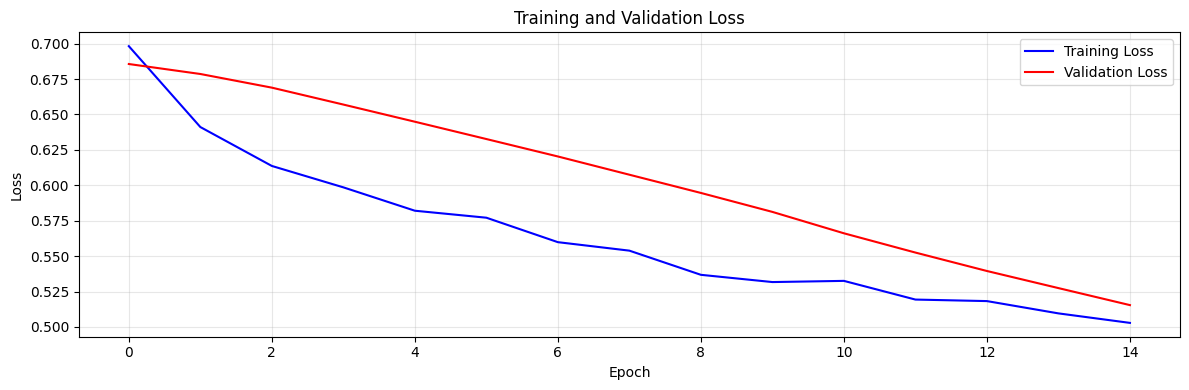


🎯 PICK ACCURACY RESULTS 
Mean absolute error: 3.6050 ± 3.4000 seconds
Median absolute error: 3.6050 seconds
90th percentile error: 6.3250 seconds
95th percentile error: 6.6650 seconds

📈 Performance Categories:
  Excellent (< 0.5s):   1 (50.0%)
  Good (0.5-1.0s):     0 (0.0%)
  Fair (1.0-2.0s):     0 (0.0%)
  Poor (> 2.0s):       1 (50.0%)


In [57]:
print("\n📊 CREATING VISUALIZATIONS")
print("-" * 50)

# Create figure with training curves and error distribution
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# Evaluate pick accuracy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

pick_errors = []

with torch.no_grad():
    for i in range(len(val_dataset)):
        features, true_label = val_dataset[i]
        features = features.unsqueeze(0).to(device)
        
        output = model(features)
        prob = output[0, 1, :].cpu().numpy()  # P-wave probability
        
        # Find predicted pick (maximum probability)
        pred_pick_sample = np.argmax(prob)
        
        # Find true pick (center of labeled window)
        true_pick_samples = np.where(true_label == 1)[0]
        if len(true_pick_samples) > 0:
            true_pick_sample = np.mean(true_pick_samples)
            
            # Calculate error in samples
            error_samples = abs(pred_pick_sample - true_pick_sample)
            pick_errors.append(error_samples)
            
# Convert errors to seconds (assuming 100 Hz sampling rate)
sampling_rate = 100
pick_errors_seconds = np.array(pick_errors) / sampling_rate

# Calculate and display metrics
print(f"\n🎯 PICK ACCURACY RESULTS ")
print("=" * 60)
print(f"Mean absolute error: {np.mean(pick_errors_seconds):.4f} ± {np.std(pick_errors_seconds):.4f} seconds")
print(f"Median absolute error: {np.median(pick_errors_seconds):.4f} seconds")
print(f"90th percentile error: {np.percentile(pick_errors_seconds, 90):.4f} seconds")
print(f"95th percentile error: {np.percentile(pick_errors_seconds, 95):.4f} seconds")

# Categorize performance
# the bounding values we put in here are definitely not recommended by any means, but they are a good starting point
# Feel free to adjust them based on your specific use case and performance expectations
excellent = np.sum(pick_errors_seconds < 0.5)
good = np.sum((pick_errors_seconds >= 0.5) & (pick_errors_seconds < 1.0))
fair = np.sum((pick_errors_seconds >= 1.0) & (pick_errors_seconds < 2.0))
poor = np.sum(pick_errors_seconds >= 2.0)

print(f"\n📈 Performance Categories:")
print(f"  Excellent (< 0.5s): {excellent:3d} ({excellent/len(pick_errors_seconds)*100:.1f}%)")
print(f"  Good (0.5-1.0s):   {good:3d} ({good/len(pick_errors_seconds)*100:.1f}%)")
print(f"  Fair (1.0-2.0s):   {fair:3d} ({fair/len(pick_errors_seconds)*100:.1f}%)")
print(f"  Poor (> 2.0s):     {poor:3d} ({poor/len(pick_errors_seconds)*100:.1f}%)")

### **Visualizing Predictions on Real Waveforms**

Now that we’ve trained the model, reviewed overall performance trends and measured its picking accuracy, let’s zoom in even further and see exactly what the model is doing—trace by trace.

This section visualizes individual waveform predictions, showing:
- The raw ground motion signal
- (If enabled) physics-informed features like STA/LTA
- The model’s predicted probability of a P-wave arrival across time

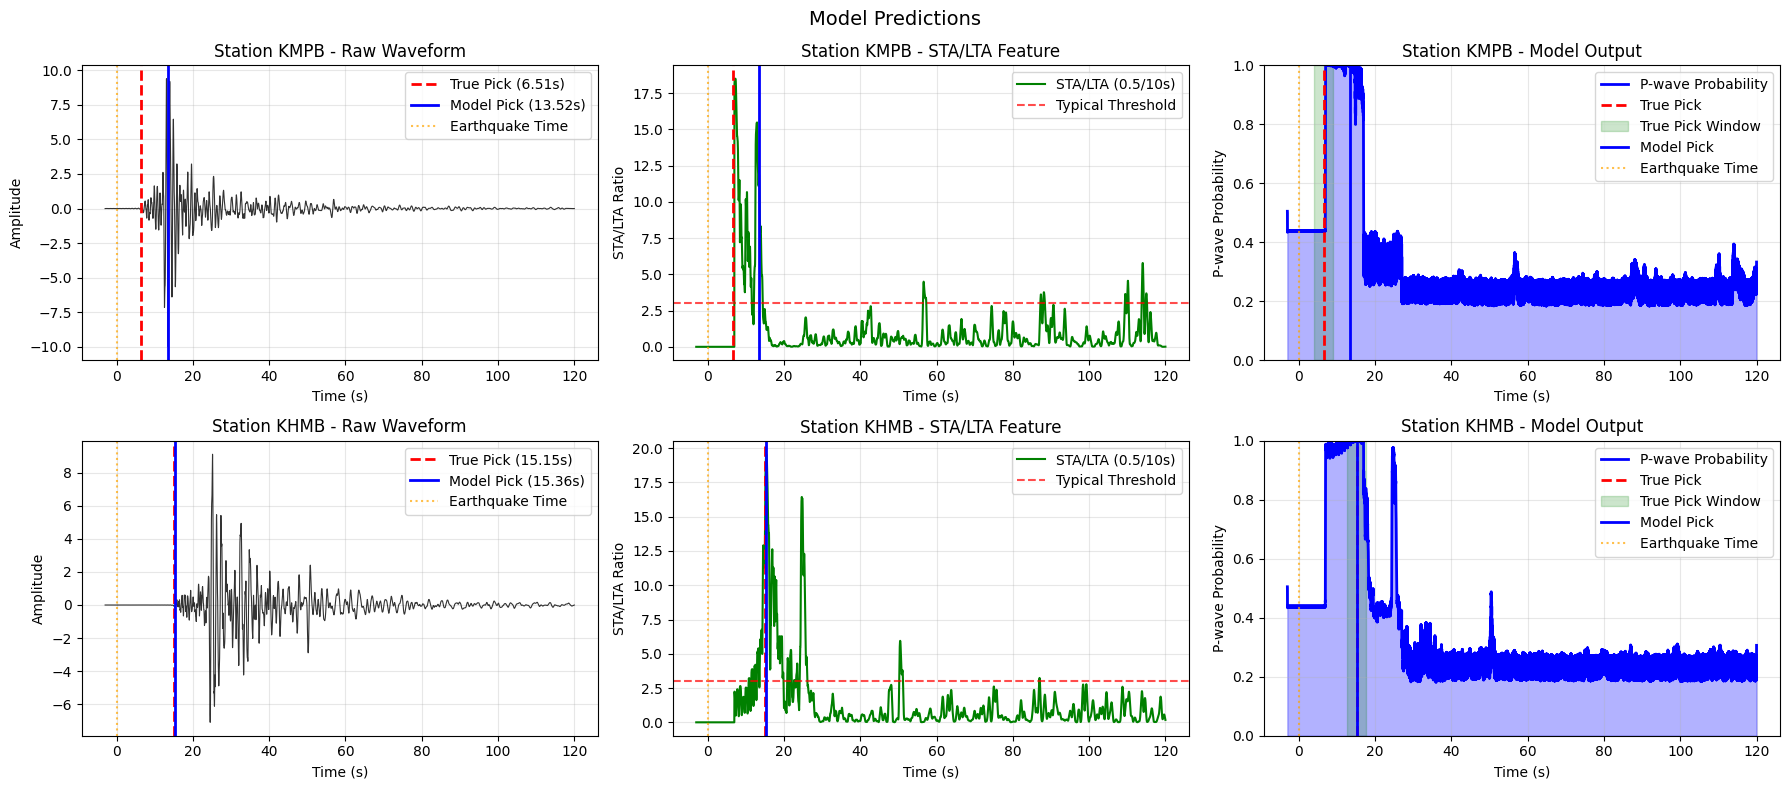

In [56]:
num_examples = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Create subplot layout
if USE_PHYSICS_FEATURES:
    fig, axes = plt.subplots(num_examples, 3, figsize=(18, 4*num_examples))
    plot_cols = 3
else:
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4*num_examples))
    plot_cols = 2

if num_examples == 1:
    axes = axes.reshape(1, -1)

# Plot predictions for each example
with torch.no_grad():
    for i in range(min(num_examples, len(val_dataset))):
        features, true_label = val_dataset[i]
        
        if i < len(val_manifest):
            station_info = val_manifest[i]
        else:
            continue
        
        # Get model prediction
        features_batch = features.unsqueeze(0).to(device)
        output = model(features_batch)
        prob = output[0, 1, :].cpu().numpy()  # P-wave probability
        
        # Time vector
        sampling_rate = station_info['sampling_rate']
        pre_time = station_info['pre_time']
        post_time = station_info['post_time']
        total_samples = features.shape[1]
        time_vector = np.linspace(-pre_time, post_time, total_samples)
        
        # Plot 1: Raw waveform
        ax1 = axes[i, 0]
        raw_waveform = features[0].numpy()
        ax1.plot(time_vector, raw_waveform, 'k-', linewidth=0.8, alpha=0.8)
        
        # Add picks
        true_pick_samples = np.where(true_label == 1)[0]
        model_pick_sample = np.argmax(prob)
        
        if len(true_pick_samples) > 0:
            true_pick_time = time_vector[int(np.mean(true_pick_samples))]
            ax1.axvline(true_pick_time, color='red', linestyle='--', linewidth=2, 
                        label=f'True Pick ({true_pick_time:.2f}s)')
        
        model_pick_time = time_vector[model_pick_sample]
        ax1.axvline(model_pick_time, color='blue', linestyle='-', linewidth=2, 
                    label=f'Model Pick ({model_pick_time:.2f}s)')
        ax1.axvline(0, color='orange', linestyle=':', alpha=0.7, label='Earthquake Time')
        
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.set_title(f'Station {station_info["station"]} - Raw Waveform')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Physics features (if applicable)
        if USE_PHYSICS_FEATURES and plot_cols == 3:
            ax2 = axes[i, 1]
            if features.shape[0] > 1:
                sta_lta = features[1].numpy()
                ax2.plot(time_vector, sta_lta, 'g-', linewidth=1.5, label='STA/LTA (0.5/10s)')
                ax2.axhline(y=3.0, color='red', linestyle='--', alpha=0.7, label='Typical Threshold')
            else:
                ax2.text(0.5, 0.5, 'No STA/LTA features', transform=ax2.transAxes, ha='center')
            
            if len(true_pick_samples) > 0:
                ax2.axvline(true_pick_time, color='red', linestyle='--', linewidth=2)
            ax2.axvline(model_pick_time, color='blue', linestyle='-', linewidth=2)
            ax2.axvline(0, color='orange', linestyle=':', alpha=0.7)
            
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('STA/LTA Ratio')
            ax2.set_title(f'Station {station_info["station"]} - STA/LTA Feature')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            prob_col = 2
        else:
            prob_col = 1
        
        # Plot 3: Model probability output
        ax3 = axes[i, prob_col]
        ax3.plot(time_vector, prob, 'b-', linewidth=2, label='P-wave Probability')
        ax3.fill_between(time_vector, 0, prob, alpha=0.3, color='blue')
        
        # Add picks and windows
        if len(true_pick_samples) > 0:
            ax3.axvline(true_pick_time, color='red', linestyle='--', linewidth=2, 
                        label='True Pick')
            window_start = time_vector[true_pick_samples[0]]
            window_end = time_vector[true_pick_samples[-1]]
            ax3.axvspan(window_start, window_end, alpha=0.2, color='green', 
                        label='True Pick Window')
        
        ax3.axvline(model_pick_time, color='blue', linestyle='-', linewidth=2, 
                    label='Model Pick')
        ax3.axvline(0, color='orange', linestyle=':', alpha=0.7, label='Earthquake Time')
        
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('P-wave Probability')
        ax3.set_title(f'Station {station_info["station"]} - Model Output')
        ax3.set_ylim(0, 1)
        ax3.legend()
        ax3.grid(True, alpha=0.3)

plt.suptitle(f'Model Predictions', fontsize=14)
plt.tight_layout()
plt.show()